## Описание проекта:

Необходимо проанализировать данные интернет магазина видеоигр для планирования рекламных кампаний. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы.

## Знакомство с данными:

In [1]:
import warnings
warnings.filterwarnings('ignore')
from scipy import stats as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('/datasets/games.csv')
print(data.info()) 
data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB
None


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


Должно быть 16715 строк. Радует, что уже много где так и есть. Две строчки без имени можно вообще удалить, тогда будет 16713. Год выпуска переведем в инт и заполним каким-нибудь str маркером, чтобы не портить метрики (хотя нужны ли будут метрики по году выпуска?). С пропусками в жанре можно поступить как и с именем, а может это все одни и те же две строки. Остальные пропуски в оценках заполним маркерами, а выводы будем делать по тому, что имеется. 

## Предобработка:

In [2]:
# переводим названия столбцов в нижний регистр
data.columns = ['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating']
data = data.dropna(subset = ['name']).reset_index() # удаляем строки без имен
data = data.dropna(subset = ['genre']).reset_index() # я честно не знал, что это будут одни и те же строки) отлично

data['year_of_release'] = data['year_of_release'].fillna(0).astype('int').replace(0, 'not_stated') 
data = data.fillna('not_stated') # заполняем отсутствующие оценки

data.info()
data.duplicated().sum() # и дубликатов нет

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16713 entries, 0 to 16712
Data columns (total 13 columns):
level_0            16713 non-null int64
index              16713 non-null int64
name               16713 non-null object
platform           16713 non-null object
year_of_release    16713 non-null object
genre              16713 non-null object
na_sales           16713 non-null float64
eu_sales           16713 non-null float64
jp_sales           16713 non-null float64
other_sales        16713 non-null float64
critic_score       16713 non-null object
user_score         16713 non-null object
rating             16713 non-null object
dtypes: float64(4), int64(2), object(7)
memory usage: 1.7+ MB


0

##### tbd:

In [3]:
data['user_score'].value_counts() # 2400 tbd

not_stated    6699
tbd           2424
7.8            324
8              290
8.2            282
              ... 
0.6              2
0.2              2
0.9              2
9.7              1
0                1
Name: user_score, Length: 97, dtype: int64

##### Rating:

In [4]:
data['rating'] = data['rating'].replace('K-A', 'E') 

Немного покапаясь в интернете я нашел информацию о том, что рейтинг K-A это старое название рейтинга Е, поэтому меняем значения

##### Колонка профит:

In [5]:
data['total_profit'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] 

16713, колонки в нижнем регистре, суммарные продажи добавлены - можно разрабатывать кампанию) tbd - to be determined/discussed/done в общем когда-нибудь будет определен. Это уже сам по себе маркер.

## Анализ данных:

##### Количество игр по годам:

In [6]:
data.query('name != "not_stated"').pivot_table(index = 'year_of_release', values = 'name', aggfunc = 'count')

,name
year_of_release,
1980,9
1981,46
1982,36
1983,17
1984,14
1985,14
1986,21
1987,16
1988,15


Не удивительно, что большинство игр было выпущено в 21 веке, однако интересно то, что пик пришелся на 2008 год, а не продолжил увеличиваться до 2016

##### Продажи по платформам:

   platform  total_profit
7       PS2       1062.33
12     X360        885.66
11      Wii        828.44
8       PS3        803.97
1        DS        746.86
6        PS        689.95
3       GBA        310.12
9       PS4        265.79
10      PSP        252.63
13       XB        249.02
2        GB        247.26
4       NES        245.74
0       3DS        245.64
5        PC        237.14
14     XOne        145.05


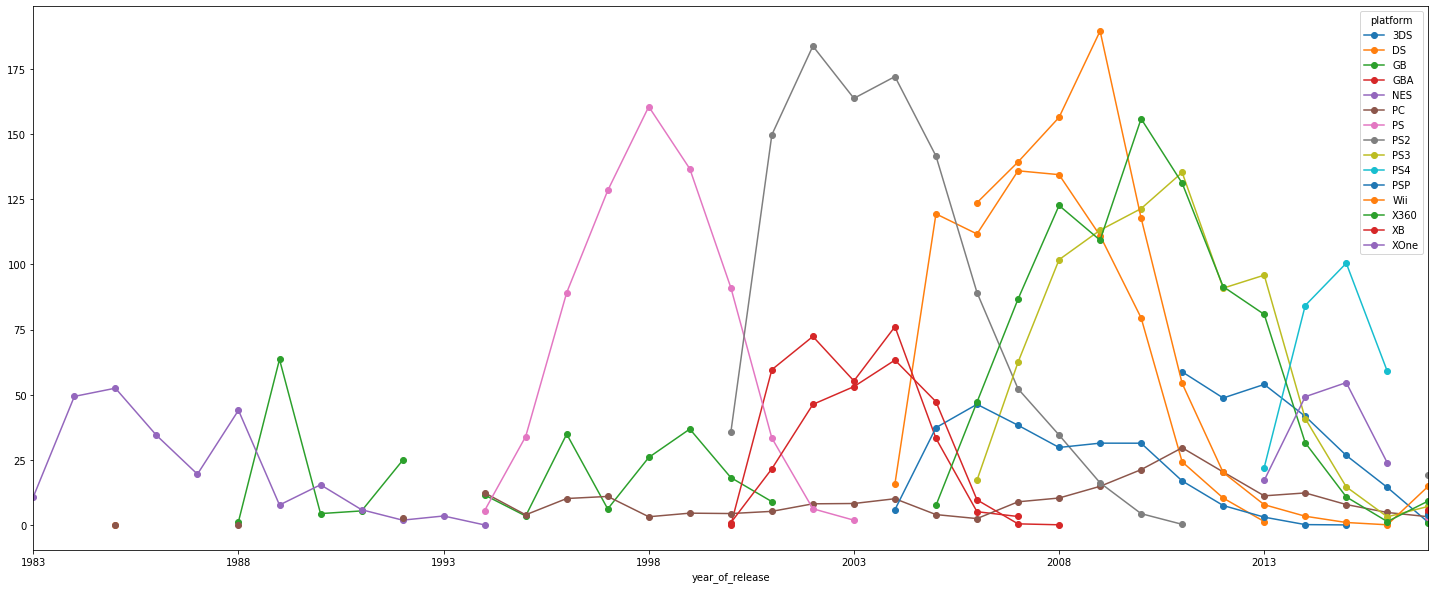

In [7]:
# сгруппируем по году выпусска и платформе
plat_sales = data.groupby(['year_of_release', 'platform'], as_index = False)['na_sales', 'eu_sales', 'jp_sales'].sum()
plat_sales['total_profit'] = plat_sales['na_sales'] + plat_sales['eu_sales'] + plat_sales['jp_sales'] 
plat_sales = plat_sales.query('platform == "PS2" or platform == "X360" or platform == "Wii" or platform == "PS3" or platform == "DS" or platform == "PS" or platform == "GBA" or platform == "PS4" or platform == "PSP" or platform == "XB" or platform == "GB" or platform == "NES" or platform == "3DS" or platform == "PC" or platform == "XOne"').sort_values('total_profit', ascending = False)

print(plat_sales.groupby('platform', as_index = False)['total_profit'].sum().sort_values('total_profit', ascending = False))
plat_sales.pivot_table(index='year_of_release', columns = 'platform', values='total_profit', aggfunc='sum').plot(style='-o', figsize = (25,10))

Полученный график по самым популярным платформам включается в себя много старых данных, которые не помогут при анализе, поэтому 
добавим в срез ограничение по году. Касательно жизненного цикла консолей - живут они очень долго. Многие из графиков простираются 10 лет и даже больше.

##### Актуальные данные:

In [8]:
# обновим датасет при помощи среза
data = data.query('platform == "X360" or platform == "Wii" or platform == "PS3" or platform == "PS" or platform == "GBA" or platform == "PS4" or platform == "XB" or platform == "GB" or platform == "NES" or platform == "3DS" or platform == "PC" or platform == "XOne"').sort_values('total_profit', ascending = False)
data['year_of_release'] = pd.to_numeric(data.query('year_of_release != "not_stated"')['year_of_release'])
data['year_of_release'] = data.query('year_of_release > 2008').dropna(subset = ['year_of_release'])

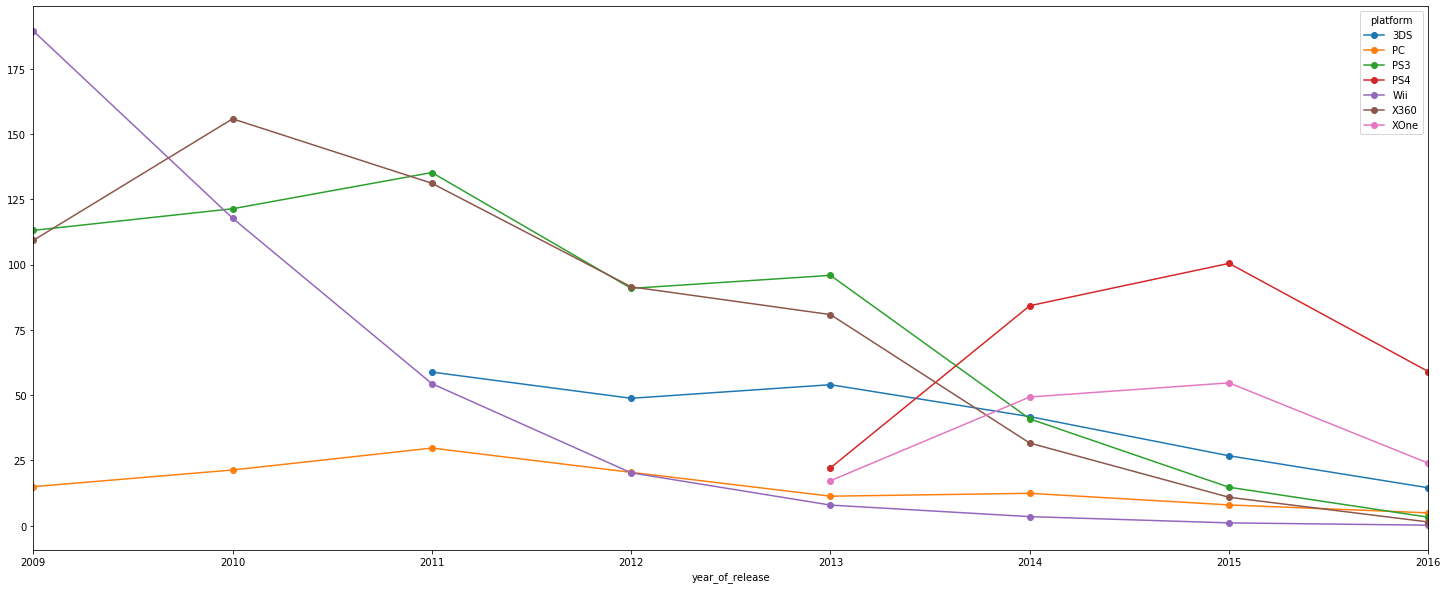

In [9]:
# также обновим данные по платформам  
plat_sales = plat_sales.query('platform == "X360" or platform == "Wii" or platform == "PS3" or platform == "PS" or platform == "GBA" or platform == "PS4" or platform == "XB" or platform == "GB" or platform == "NES" or platform == "3DS" or platform == "PC" or platform == "XOne"').sort_values('total_profit', ascending = False)
plat_sales['year_of_release'] = pd.to_numeric(plat_sales.query('year_of_release != "not_stated"')['year_of_release'])
plat_sales['year_of_release'] = plat_sales.query('year_of_release > 2008').dropna(subset = ['year_of_release'])

#print(plat_sales.groupby('platform', as_index = False)['total_profit'].sum().sort_values('total_profit', ascending = False))
plat_sales.pivot_table(index='year_of_release', columns = 'platform', values='total_profit', aggfunc='sum').plot(style='-o', figsize = (25,10))


Теперь видно намного лучше. Так же я убрал из среза PS2 и DS так как данные о них заканчивались где-то в 2012 и добавил Xbox One, который вышел в одно время с PS4. Также ушла эпоха PSP. Остальные, пропавшие с графика консоли, отсеялись срезом по времени. Говоря об актуальности оставшихся платформ, очевидным лидером является PS4 (еслибы я тогда покупал консоль, то тоже бы взял его)). Конкурировать с ним пытается новая модель Xbox-а. 3 версия плойки устаревает вместе со старой "коробкой 360". Компьютер никогда не был особенно популярен, зато всегда стабилен так как есть у всех.

##### Ящики с усами:

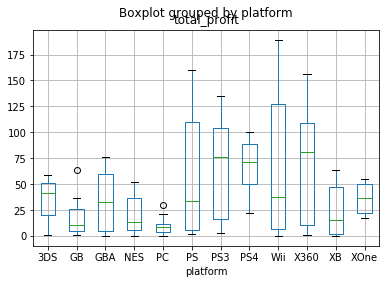

In [10]:
plat_sales.boxplot('total_profit', by = 'platform')

##### Влияние  отзывов пользователей и критиков на продажи внутри одной популярной платформы:

Корреляция с оценками пользователей: -0.03292287016409417
Корреляция с оценками критиков: 0.4052233666150137


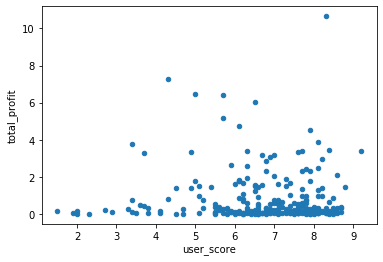

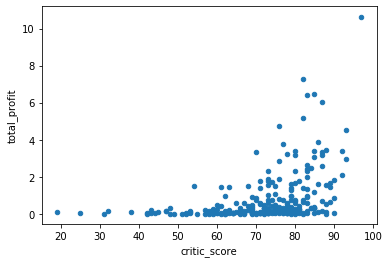

In [11]:
ps4 = data.query('platform == "PS4" and user_score != ["not_stated", "tbd"] and critic_score != ["not_stated", "tbd"]') # берем самую многообещающую платформу
ps4['user_score'] = pd.to_numeric(ps4['user_score'])
ps4['critic_score'] = pd.to_numeric(ps4['critic_score'])
ps4['total_profit'] = ps4['na_sales'] + ps4['eu_sales'] + ps4['jp_sales']

ps4.plot.scatter(x = 'user_score', y = 'total_profit') # график юзеров
print('Корреляция с оценками пользователей:', ps4['user_score'].corr(ps4['total_profit']))

ps4.plot.scatter(x = 'critic_score', y = 'total_profit') # график критиков
print('Корреляция с оценками критиков:', ps4['critic_score'].corr(ps4['total_profit']))

Чем выше оценки, тем больше точек на диаграмме. Зависят ли продажиот оценок? Скорее хорошие игры просто хорошо продаются и имеют хорошие оценки. А ещё оценки пользователей ожидаемо более разбросанны. Видимо из-за этого испортился коэффициент корреляции 

##### Продажи по жанрам:

In [12]:
genre_list = data['genre'].unique()
for i in genre_list: # наглядно покажем все доходы по жанрам
    print('profit in {} genre:'.format(i), data.query('genre == @i')['total_profit'].sum().round().astype('int'))

profit in Sports genre: 809
profit in Platform genre: 448
profit in Racing genre: 370
profit in Role-Playing genre: 553
profit in Puzzle genre: 113
profit in Shooter genre: 752
profit in Misc genre: 458
profit in Action genre: 1036
profit in Fighting genre: 212
profit in Adventure genre: 129
profit in Simulation genre: 171
profit in Strategy genre: 102


Выделим наиболее и наименее прибыльные. К первым относятся Action - 1560, Sports - 1197 и Shooter - 948, причем 1 и 3 жанр часто идут рука об руку. Последние места занимают Strategy - 163, Adventure - 221 и Puzzle - 230

## Портреты пользователей:

##### Самые популярные платформы:

In [13]:
def profiler(index, values): # Выводит топ 5 того, что нам захочется
    print('Top 5 {}s according to {}:'.format(index, values))
    print(data.pivot_table(index = index, values = values, aggfunc = 'sum').sort_values(values , ascending = False).head())
    print()
    
    
profiler('platform', 'na_sales')
profiler('platform', 'eu_sales')
profiler('platform', 'jp_sales')

Top 5 platforms according to na_sales:
          na_sales
platform          
X360        602.47
Wii         496.90
PS3         393.49
PS          336.52
GBA         187.54

Top 5 platforms according to eu_sales:
          eu_sales
platform          
PS3         330.29
X360        270.76
Wii         262.21
PS          213.61
PC          142.44

Top 5 platforms according to jp_sales:
          jp_sales
platform          
PS          139.82
3DS         100.67
NES          98.65
GB           85.12
PS3          80.19



##### Cамые популярные жанры:

In [14]:
profiler('genre', 'na_sales')
profiler('genre', 'eu_sales')
profiler('genre', 'jp_sales')

Top 5 genres according to na_sales:
          na_sales
genre             
Action      570.08
Sports      464.04
Shooter     462.85
Misc        280.12
Platform    252.58

Top 5 genres according to eu_sales:
              eu_sales
genre                 
Action          375.66
Sports          273.83
Shooter         265.28
Racing          148.43
Role-Playing    144.13

Top 5 genres according to jp_sales:
              jp_sales
genre                 
Role-Playing    183.54
Action           90.35
Platform         79.35
Sports           71.36
Misc             40.67



Role-play в Японии на первом месте вполне ожидаем. В остальных представленных регионах жанр Action подтверждает свое первенство

##### Влияние рейтинга ESRB на продажи в отдельном регионе:

In [15]:
print(data.query('rating != "not_stated"').pivot_table(index = 'rating', values = 'na_sales', aggfunc = 'sum').sort_values('na_sales', ascending = False))
print()
print(data.query('rating == "T"')['rating'].value_counts())
print(data.query('rating == "E10+"')['rating'].value_counts())

        na_sales
rating          
E         749.92
M         618.84
T         477.69
E10+      231.63
AO          1.26
EC          0.71
RP          0.00

T    1798
Name: rating, dtype: int64
E10+    829
Name: rating, dtype: int64


Тут вообще очень логичная связь. Очевидно, что игры с рейтингом E(Everyone) разойдутся намного лучше, чем любой другой рейтинг, подразумевающий ограничения. Достаточно просто взглянуть на выручку категории AO (Adults only). Хотя продажи так же зависят от количества игр с присвоенным рейтингом, например в нашей выборке игр с рейтингом Т вдвое больше E10+ 

## Проверка гипотез:

##### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые:

In [16]:
x_one = pd.to_numeric(data.query('platform == "XOne" and user_score != "not_stated" and user_score != "tbd"')['user_score']) 
pc = pd.to_numeric(data.query('platform == "PC" and user_score != "not_stated" and user_score != "tbd"')['user_score'])

results = st.ttest_ind(x_one, pc)
results.pvalue

1.3896435533548819e-05

P-value = 1,3 / 10^(-5) = очень маленкое число) ==> отвергаем нулевую гипотезу о том, что средние выборок равно. Выведем среднее и посмотрим, кто круче. Ставлю на pc.  

In [17]:
print('X-Box mean:', x_one.mean())
print('PC mean:', pc.mean())

X-Box mean: 6.521428571428572
PC mean: 7.062467532467533


##### Средние пользовательские рейтинги жанров Action и Sports разные:

In [18]:
action = pd.to_numeric(data.query('genre == "Action" and user_score != "not_stated" and user_score != "tbd"')['user_score'])
sports = pd.to_numeric(data.query('genre == "Sports" and user_score != "not_stated" and user_score != "tbd"')['user_score'])

results = st.ttest_ind(action,sports)
results.pvalue

3.795447001768744e-05

Что 1 в (-5), что 3 в (-5) - разницы особой нет. Отвергаем гипотезу о равенстве и проверяем среднее.

In [19]:
print('Action mean:', action.mean())
print('Sports mean:', sports.mean())

Action mean: 6.941295546558704
Sports mean: 6.642274052478134


## Общийй вывод:

Итак, вывод. Начнем с консолей. Изначально можно было предположить, что лавры будут делить вечные конкуренты PS4 и X-Box One. Так и есть, вместе они приносят примерно столько же, сколько все остальные вместе взятые. Также маленький угол наклона у графика 3DS говорит нам о том, что у консоли ещё есть силы. Относительно жанров - всегда можно поставить на экшн и попасть в точку. Хотя, как мы выяснили из популярности жанров по регионам, если вдруг наш магазин "Стримчик" ведет свою деятельность в Японии, то лучше присмотреться к Role-play. Sports и Action тоже очень хорошо заходят. Касательно рейтингов, исходя из данных, лучше попасть в какую-нибудь распространенную категорию типа Е или Е10+ / Т. Хотя хочется добавить немного отсебятины, ибо я никогда не обращал внимания ни на какие рейтинги распределения пользователей на категории такие как данный ESRB. Мне кажется пользователи больше смотрят на отзывы первых покупателей и смотрят обзоры на игры в ютубе. Гипотезы: у компьютера пользовательский рейтинг выше чем у одного из фаворитов - X-Box. Возможно не стоит списывать компьютер со счетов, а если ещё и какой-нибудь эксклюзивный шутер на пк подвернется, то вообще прекрасно. Хотя эксклюзивы - это обычно удел консолей, а на пк те же самые игры если и выпускаются, то с большим опозданием. Средние рейтинги у двух самых популярных жанров различаются - просто ещё одно подтверждение, что экшн нравится людям больше, чем что либо другое, но это, конечно,  не значит, что нужно забывать про спорт.     